### Chapter 15 ML Engineering in Action
Author: Ben Wilson

##### Overview
This notebook is simply the source code for generating the plots used in section 15.3 for the scenario being used. We clearly aren't going to be actually building the Siamese network here since music not in the public domain is hard to come by. I'm just including the generation of these images here for reference in case you're curious.

##### NOTE
These fourier transforms are pretty memory and CPU intensive. If you don't allocate more resources to the docker container running this, your kernel will likely crash. I recommend at least 6GB of memory and 4 cores if you'd like to play around with this code.

In [21]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import audio2numpy
import librosa          # 각각 따로 import해야 에러 없음
import librosa.display  # 각각 따로 import해야 에러 없음
from collections import namedtuple

In [22]:
# beethoven_url = "https://freemusicarchive.org/track/Beethoven_-_Sonata_No_31_in_A_Flat_Major_Op_110_-_I_Moderato_cantabile_molto_espressivo/download"
# mozart_url = "https://freemusicarchive.org/track/Advent_Chamber_Orchestra_-_04_-_Mozart_-_A_Little_Night_Music_allegro/download"

In [95]:
def download_classical(url, file_name):
    response = requests.get(url, stream=True)
    with open(file_name, "wb") as song:
        song.write(response.content)
    response.close()

def get_audio_file(file_name):
    Song = namedtuple('Song', 'data sample_rate')
    data, sr = audio2numpy.audio_from_file(file_name)
    return Song(data, sr)

def download_and_return_audio(url, file_name):
    download_classical(url, file_name)
    return get_audio_file(file_name)

def get_audio_channels(song_data, sample=5000000):
    Channels = namedtuple('Channels', 'left right sample_rate')
    left = song_data.data[:,0][:sample]
    right = song_data.data[:,1][:sample]
    return Channels(left, right, song_data.sample_rate)

def extract_mel_spec(channel_data, sample_rate, mels=128, fmax=12000):
    Mel = namedtuple('Mel', 'S dB')
    S = librosa.feature.melspectrogram(y=channel_data, sr=sample_rate, n_mels=mels, fmax=fmax)
    dB = librosa.power_to_db(S, ref=np.max)
    return Mel(S, dB)

def extract_db_scale(channel_data):
    return librosa.amplitude_to_db(np.abs(librosa.stft(channel_data)), ref=np.max)

# 옵션 seaborn에서 에러 발생 (250207)

def generate_spectrogram(channel_data, sample_rate, piece_name, mels=128, fmax=22000):
    #with plt.style.context('seaborn'):         # 에러 발생
    with plt.style.context('_mpl-gallery'):     # 다른 스타일로 변경 : 에러는 해결 (250207)
        fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10,20))
        
        harmonic, percussion = librosa.effects.hpss(channel_data)
        
        librosa.display.waveshow(harmonic, sr=sample_rate, alpha=0.5, ax=ax[0], label="Harmonic")
        librosa.display.waveshow(percussion, sr=sample_rate, alpha=0.5, ax=ax[0], label="Percussion")
        
        ax[0].set(title=f"Harmonic and Percussive Waveforms for {piece_name}")
        ax[0].legend(loc='best')
        ax[0].set_ylim([-.5, .5])
        
        mel = extract_mel_spec(channel_data, sample_rate, mels, fmax)
        librosa.display.specshow(mel.S, x_axis='time', y_axis='mel', sr=sample_rate, fmax=fmax, ax=ax[1])
        ax[1].set(title=f"Mel spectrogram for {piece_name}")
        img = librosa.display.specshow(extract_db_scale(channel_data), y_axis='linear', x_axis='time', 
                                       sr=sample_rate, ax=ax[1])
        
        mel_1 = extract_mel_spec(harmonic, sample_rate, mels, fmax)
        librosa.display.specshow(mel_1.S, x_axis='time', y_axis='mel', sr=sample_rate, fmax=fmax, ax=ax[2])
        ax[2].set(title=f"Mel spectrogram for {piece_name}")
        img = librosa.display.specshow(extract_db_scale(harmonic), y_axis='linear', x_axis='time', 
                                       sr=sample_rate, ax=ax[2])
        
        mel_2 = extract_mel_spec(percussion, sample_rate, mels, fmax)
        librosa.display.specshow(mel_2.S, x_axis='time', y_axis='mel', sr=sample_rate, fmax=fmax, ax=ax[3])
        ax[3].set(title=f"Mel spectrogram for {piece_name}")
        img = librosa.display.specshow(extract_db_scale(percussion), y_axis='linear', x_axis='time', 
                                       sr=sample_rate, ax=ax[3])
        
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        #plt.savefig(f"{piece_name}_spec.svg", format='svg', pad_inches=0)
        #plt.savefig(f"{piece_name}_spec.png", format='png', pad_inches=0)
    plt.show()


In [96]:
# beethoven = download_and_return_audio(beethoven_url, "beethoven.mp3")
# mozart = download_and_return_audio(mozart_url, "mozart.mp3")

In [97]:
## mp3 파일 직접 로딩 (250208)

beethoven = get_audio_file("beethoven.mp3")

In [98]:
beethoven_channels = get_audio_channels(beethoven, sample=200000000)
# mozart_channels = get_audio_channels(mozart, sample=2000000)

In [99]:
import IPython.display as ipd

xh, sr_h = librosa.load('beethoven.mp3', duration=7, sr=None)
ipd.Audio(xh, rate=sr_h)

In [100]:
ipd.Audio(beethoven_channels.left, rate=sr_h)   # 스테레오 채널이므로 한 쪽(모노) 신호만 로딩 (250207)

In [101]:
import matplotlib
print(matplotlib.__version__)

3.7.0


In [102]:
import matplotlib.pyplot as plt
# plt.style.use(['science', 'notebook'])
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


c:\Users\wonta\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


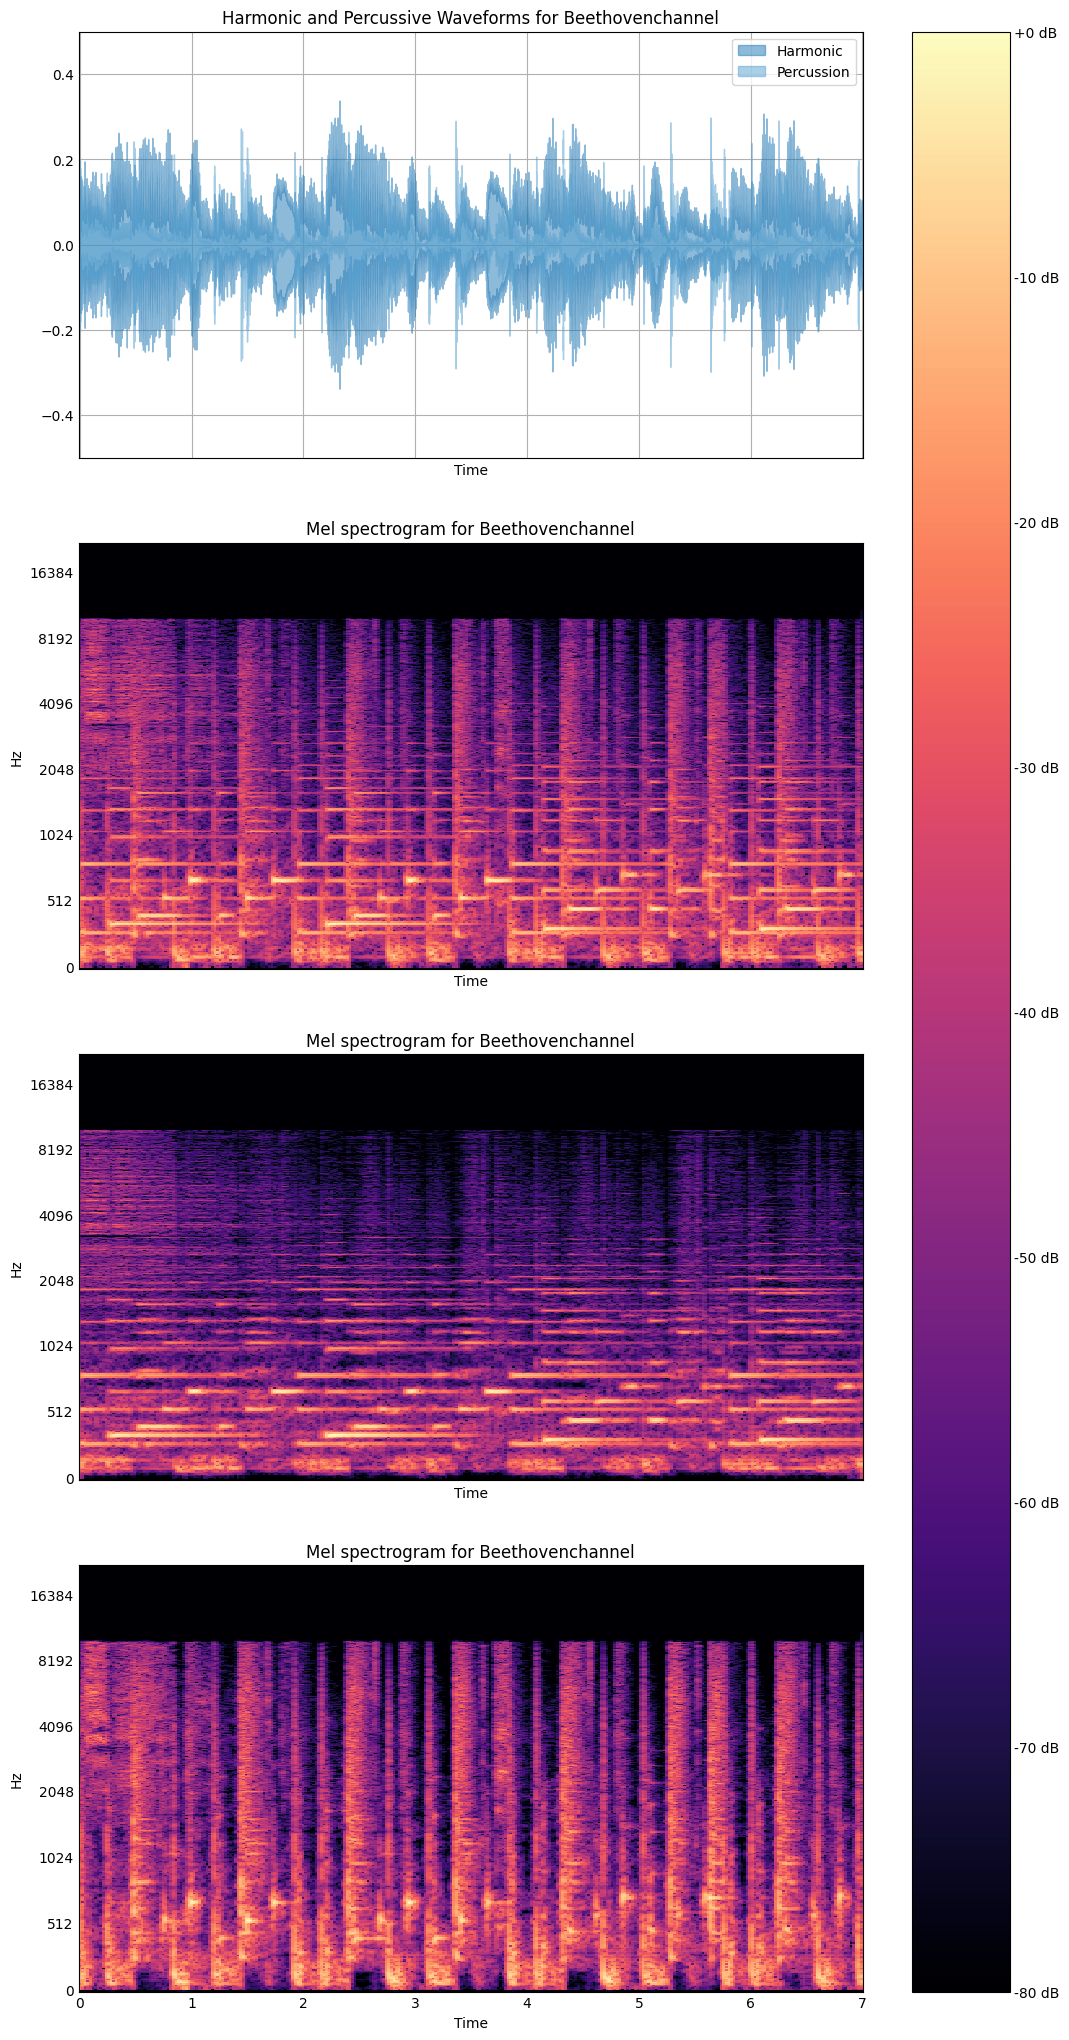

In [103]:
generate_spectrogram(beethoven_channels.left, sr_h, "Beethovenchannel")

In [ ]:
## matplotlib 버전 3.7로 다운 설치 후 정상 실행 확인 (250208)